## Import dependencies

In [91]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas_datareader as pdr
from datetime import datetime
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from functools import partial
from scipy.integrate import quad

from matplotlib import pyplot as plt
import utils
import alPhaStablePricer as alpha
import ghPricer as gh
import mertonPricer as merton

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-14,24.620001,24.187500,24.330000,24.365000,127727600.0,22.761415
2016-06-15,24.602501,24.257500,24.455000,24.285000,117780800.0,22.686680
2016-06-16,24.437500,24.017500,24.112499,24.387501,125307200.0,22.782436
2016-06-17,24.162500,23.825001,24.155001,23.832500,244032800.0,22.263964
2016-06-20,24.142500,23.757500,24.000000,23.775000,137647600.0,22.210251
...,...,...,...,...,...,...
2021-06-07,126.320000,124.830002,126.169998,125.900002,71057600.0,125.900002
2021-06-08,128.460007,126.209999,126.599998,126.739998,74403800.0,126.739998
2021-06-09,127.750000,126.519997,127.209999,127.129997,56877900.0,127.129997


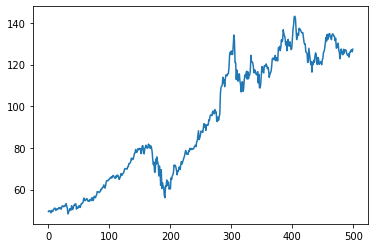

In [92]:
df = pdr.data.DataReader("AAPL",'yahoo', #"av-intraday",
                         end=datetime.today(),
                         api_key="ZDT39A5EINVODTVI")
display(df)
df["Close"][-500:].plot(use_index=False)
initial_value=df["Close"][-1]
df.index = pd.to_datetime(df.index)

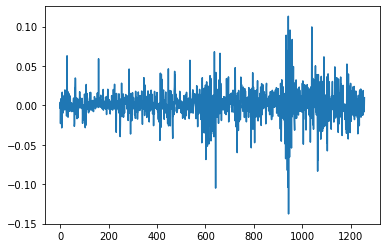

Date
2016-06-15   -0.003289
2016-06-16    0.004212
2016-06-17   -0.023021
2016-06-20   -0.002416
2016-06-21    0.008481
Name: Close, dtype: float64

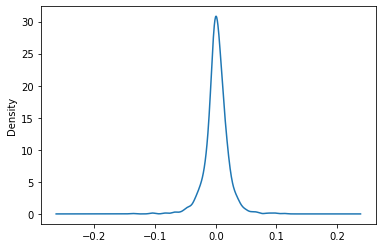

In [93]:
df = pd.Series(np.log(df.Close) - np.log(df.Close.shift(1))[1:],index=df.index[1:])
df.plot(use_index=False)
plt.show()
df.plot.kde()
df.head()

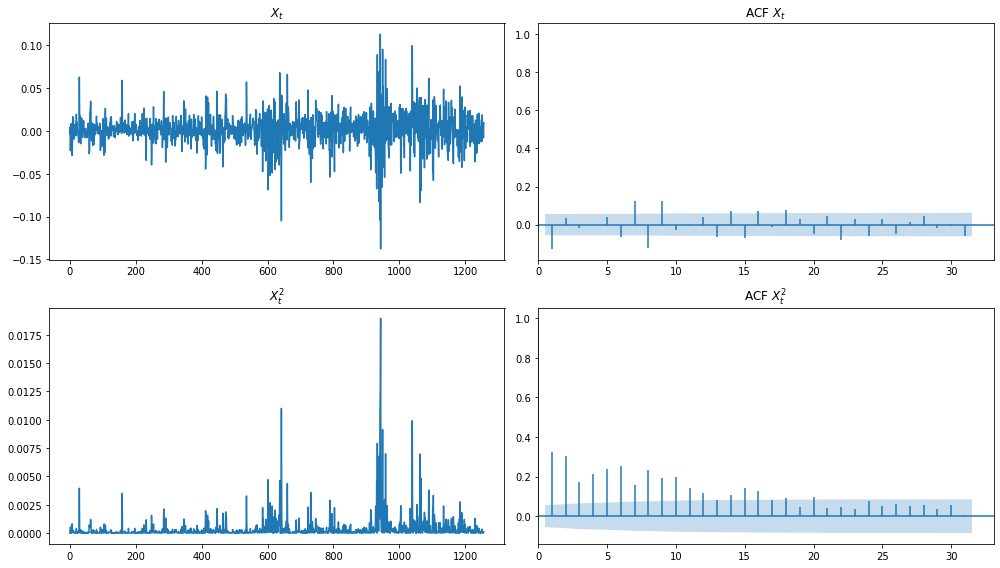

In [94]:
def tsplot(y, figsize=(14, 8),xlim=(-0.1,0.1)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    ac_ax = plt.subplot2grid(layout, (0, 1))
    ts_ax2  = plt.subplot2grid(layout, (1, 0))
    ac_ax2 = plt.subplot2grid(layout, (1, 1))
    
    y2=pd.Series([x**2 for x in y])

    y.plot(ax=ts_ax,use_index=False,title=r'$X_t$')
    y2.plot(ax=ts_ax2,use_index=False,title=r'$X_t^2$')
    
    smt.graphics.plot_acf(y, lags=None, ax=ac_ax,marker=None,title=r'ACF $X_t$')
    smt.graphics.plot_acf(y2, lags=None, ax=ac_ax2,marker=None,title=r'ACF $X_t^2$')
    
    [ax.set_xlim(0) for ax in [ac_ax, ac_ax2]]

    
    fig.tight_layout()
    plt.show()
tsplot(df)

## Data subset

In [95]:
dataset = df[-250:]

In [96]:
dataset

Date
2020-06-16    0.026157
2020-06-17   -0.001393
2020-06-18    0.000398
2020-06-19   -0.005731
2020-06-22    0.025827
                ...   
2021-06-07    0.000079
2021-06-08    0.006650
2021-06-09    0.003072
2021-06-10   -0.008056
2021-06-11    0.009785
Name: Close, Length: 250, dtype: float64

In [97]:
print("Shapiro test of normality: statistic={}, p_value={}".format(st.shapiro(dataset)[0],st.shapiro(dataset)[1]))

Shapiro test of normality: statistic=0.9776006937026978, p_value=0.0005543507868424058


In [98]:
print("Jarque Bera test of normality: statistic={}, p_value={}".format(st.jarque_bera(dataset)[0],st.shapiro(dataset)[1]))

Jarque Bera test of normality: statistic=47.12679747746552, p_value=0.0005543507868424058


We can reject the null hypothesis H0 that the returns are normally distributed

## Fit models

In [99]:
alpha_model = alpha.AlPhaStablePricer()

In [100]:
alpha_model.fit(dataset)

/home/ubuntu/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4530: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


In [101]:
merton_model = merton.MertonPricer()

In [102]:
merton_model.fit(dataset,T=1)

In [103]:
gh_model = gh.GhPricer()

In [104]:
gh_model.fit(dataset,100)

/home/ubuntu/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


## Probability density

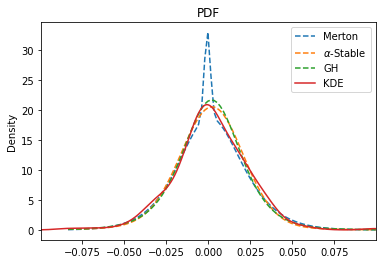

In [105]:
N=100
x_grid = np.linspace(dataset.min(),dataset.max(),N)

plt.plot(x_grid,
        [merton_model.Merton_density(j,
                                     T=1,
                                     lam= merton_model.lam,
                                     mu=merton_model.mu,
                                     muJ=merton_model.muJ,
                                     sig=merton_model.sig,
                                     sigJ=merton_model.sigJ) for j in x_grid],
        label="Merton",linestyle='--')


plt.plot(x_grid,
         [st.levy_stable.pdf(x, 
                          alpha=alpha_model.alpha,
                          beta=alpha_model.betta,
                          loc=alpha_model.mu,
                          scale=alpha_model.c) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')


plt.plot(x_grid,
        [gh_model.GH_density(j,
                             alpha= gh_model.alpha,
                             betta=gh_model.betta,
                             delta=gh_model.delta,
                             lam=gh_model.lam,
                             mu=gh_model.mu) for j in x_grid],
        label="GH",linestyle='--')


dataset.plot.kde(label="KDE")
plt.xlim((-dataset.max(),dataset.max()))
plt.legend()
plt.title("PDF")
plt.show()

## Cumulative distribution function

<ipython-input-106-c0968c7db0fa>:22: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  [quad(p_GH,-np.inf,x)[0] for x in x_grid],


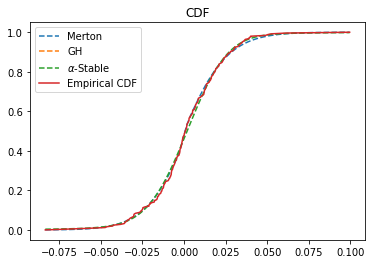

In [106]:
p_Merton = partial(merton_model.Merton_density,
                  T=1,
                  lam= merton_model.lam,
                  mu=merton_model.mu,
                  muJ=merton_model.muJ,
                  sig=merton_model.sig,
                  sigJ=merton_model.sigJ)

p_GH = partial(gh_model.GH_density,
               delta=gh_model.delta,
               mu=gh_model.mu,
               lam=gh_model.lam,
               alpha=gh_model.alpha,
               betta=gh_model.betta)


plt.plot(x_grid,
        [quad(p_Merton,-np.inf,x)[0] for x in x_grid],
        label="Merton",linestyle='--')

plt.plot(x_grid,
        [quad(p_GH,-np.inf,x)[0] for x in x_grid],
        label="GH",linestyle='--')

plt.plot(x_grid,  
        [st.levy_stable(alpha=alpha_model.alpha,
                        beta=alpha_model.betta,
                        loc=alpha_model.mu,
                        scale=alpha_model.c).cdf(x) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')
 
plt.plot(np.sort(dataset), 1. * np.arange(len(dataset)) / (len(dataset) - 1),label="Empirical CDF")
plt.legend()
plt.title("CDF")
plt.show()

### AIC

In [107]:
pd.DataFrame({"Merton":merton_model.aic,
              "GH":gh_model.aic,
              "Alpha-Stable":alpha_model.aic}.items(),
             columns=["Model","AIC"]).sort_values("AIC")

,Model,AIC
0,Merton,-1210.398222
2,Alpha-Stable,-1208.581236
1,GH,-1207.732442


## Pricing

In [108]:
r=2/100
S0=initial_value
K=127
T=1
print(S0)
print(T)

127.3499984741211
1


###  Martingale corrections

In [109]:
cf_mert_mcm = partial(merton_model.cf_mert,
                       t=T,
                       mu= merton_model.mu-merton_model.mcm,
                       sig= merton_model.sig,
                       lam= merton_model.lam,
                       muJ= merton_model.muJ,
                       sigJ= merton_model.sigJ)

cf_stable_mcm = alpha_model.cf_stable(
                        t=T,
                        alpha=alpha_model.alpha,
                        betta=alpha_model.betta,
                        mu=alpha_model.mu-alpha_model.mcm,
                        c=alpha_model.c)




cf_GH_mcm = partial(gh_model.cf_GH,
                    t=T,
                    delta = gh_model.delta,               
                    mu= gh_model.mu-gh_model.mcm,
                    lam= gh_model.lam,
                    alpha=gh_model.alpha,
                    betta=gh_model.betta)
                    
print(alpha_model.mcm)
print(merton_model.mcm)
print(gh_model.mcm)

(-0.0003751539780982368+0.0013895810461726512j)
(0.0018162949195840933+0j)
(4.9086497716154325+0j)


### Results

In [110]:
data = [{'model': "Stable",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="call",T=T,udep=False,mcm=alpha_model.mcm),
         "Call_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10000)[0],
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="put",T=T,udep=False,mcm=alpha_model.mcm),
         "Put_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=10000)[0]},
       {'model': "Merton",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="call",T=T,udep=True,mcm=merton_model.mcm),
         "Call_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=10000)[0],
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="put",T=T,udep=True,mcm=merton_model.mcm),
         "Put_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=10000)[0]},
       {'model': "GH",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="call",T=T,udep=True,mcm=gh_model.mcm),
         #"Call_MC":gh_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=1)[0],
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="put",T=T,udep=True,mcm=gh_model.mcm),
         #"Put_MC":gh_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=1)[0]
       }]
        
pd.DataFrame.from_dict(data)

,model,Call_Fourier,Call_MC,Put_Fourier,Put_MC
0,Stable,2.739967,3.261279,-0.124800,0.206710
1,Merton,3.711622,3.117181,0.846855,0.199594
2,GH,2.521700,NaN,-0.343067,NaN


## Plots

In [111]:
S = [i for i in range(1,200)]
plots= [{'model': "Stable",
         "Call_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_stable_mcm,payoff="call",T=T,udep=False,mcm=alpha_model.mcm) for s in S],
         "Call_MC":[alpha_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="call",N=10000)[0] for s in S],
         "Put_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_stable_mcm,payoff="put",T=T,udep=False,mcm=alpha_model.mcm) for s in S],
         "Put_MC":[alpha_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="put",N=10000)[0]for s in S]},
       {'model': "Merton",
         "Call_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_mert_mcm,payoff="call",T=T,udep=True,mcm=merton_model.mcm) for s in S],
         "Call_MC":[merton_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="call",N=10000)[0]for s in S],
         "Put_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_mert_mcm,payoff="put",T=T,udep=True,mcm=merton_model.mcm) for s in S],
         "Put_MC":[merton_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="put",N=10000)[0]for s in S]},
       {'model': "GH",
         "Call_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_GH_mcm,payoff="call",T=T,udep=True,mcm=gh_model.mcm) for s in S],
         #"Call_MC":[gh_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="call",N=50)[0]for s in S],
         "Put_Fourier":[utils.fourierPricer(K=K,S0=s,r=r,cf=cf_GH_mcm,payoff="put",T=T,udep=True,mcm=gh_model.mcm) for s in S],
         #"Put_MC":[gh_model.mcPricer(K=K,r=r,T=T,S0=s,payoff="put",N=1)[0]for s in S]
       }]

/home/ubuntu/TFM/utils.py:30: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(integrand, 0, xmax, limit=limit)[0]


## CALLS

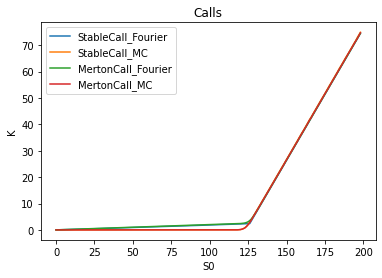

In [120]:
for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Put_Fourier") and (j!="Put_MC")):
            #if i["model"]!="GH":
            #if ((i["model"]+j)!="GHCall_MC"):
            plt.plot(i[j],label=i["model"]+j)
plt.title("Calls")
plt.xlabel("S0")
plt.ylabel("K")
plt.legend()

plt.show()

## Puts

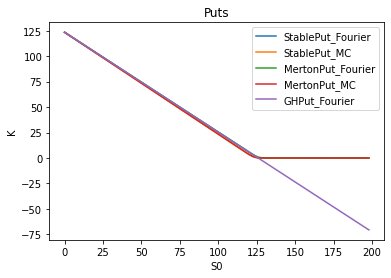

In [119]:
for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Call_Fourier") and (j!="Call_MC")):
            #f i["model"]!="GH":
            plt.plot(i[j],label=i["model"]+j)
plt.xlabel("S0")
plt.ylabel("K")
plt.legend()
plt.title("Puts")
plt.show()

In [114]:
from scipy.optimize import fsolve

fsolve(lambda x:1.43-1.08- S0 + K*np.exp(-r*x),x0=1)

array([6.00739726e-07])

In [115]:
6/275

0.02181818181818182